# statistics

> Necessary scripts to read orbits from different formats

In [ ]:
#| default_exp stats

In [ ]:
#| export
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#| hide
#| export
from orbit_generation.reader import get_example_orbit_data

In [ ]:
mat_data= get_example_orbit_data()
mat_data.shape

(200, 6, 300)

## Simple statistics

In [ ]:
#| export
def plot_histograms(data):
    """
    Plots histograms for the 6 scalar values (position and velocity in X, Y, Z) across all orbits and time points.
    
    :param data: numpy.ndarray, shape (num_orbits, 6, num_time_points), containing orbit data.
    """
    scalar_names = ['posX', 'posY', 'posZ', 'velX', 'velY', 'velZ']
    num_scalars = len(scalar_names)
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the subplot layout as necessary
    fig.suptitle('Histograms of Position and Velocity Components Across All Orbits')
    
    for i in range(num_scalars):
        scalar_values = data[:, i, :].flatten()  # Flatten combines all orbits and time points for each scalar
        
        row, col = divmod(i, 3)  # Determine subplot position
        axs[row, col].hist(scalar_values, bins=50, alpha=0.75)  # You can adjust the number of bins
        axs[row, col].set_title(f'{scalar_names[i]}')
        axs[row, col].set_ylabel('Frequency')
        axs[row, col].set_xlabel('Value')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title
    plt.show()



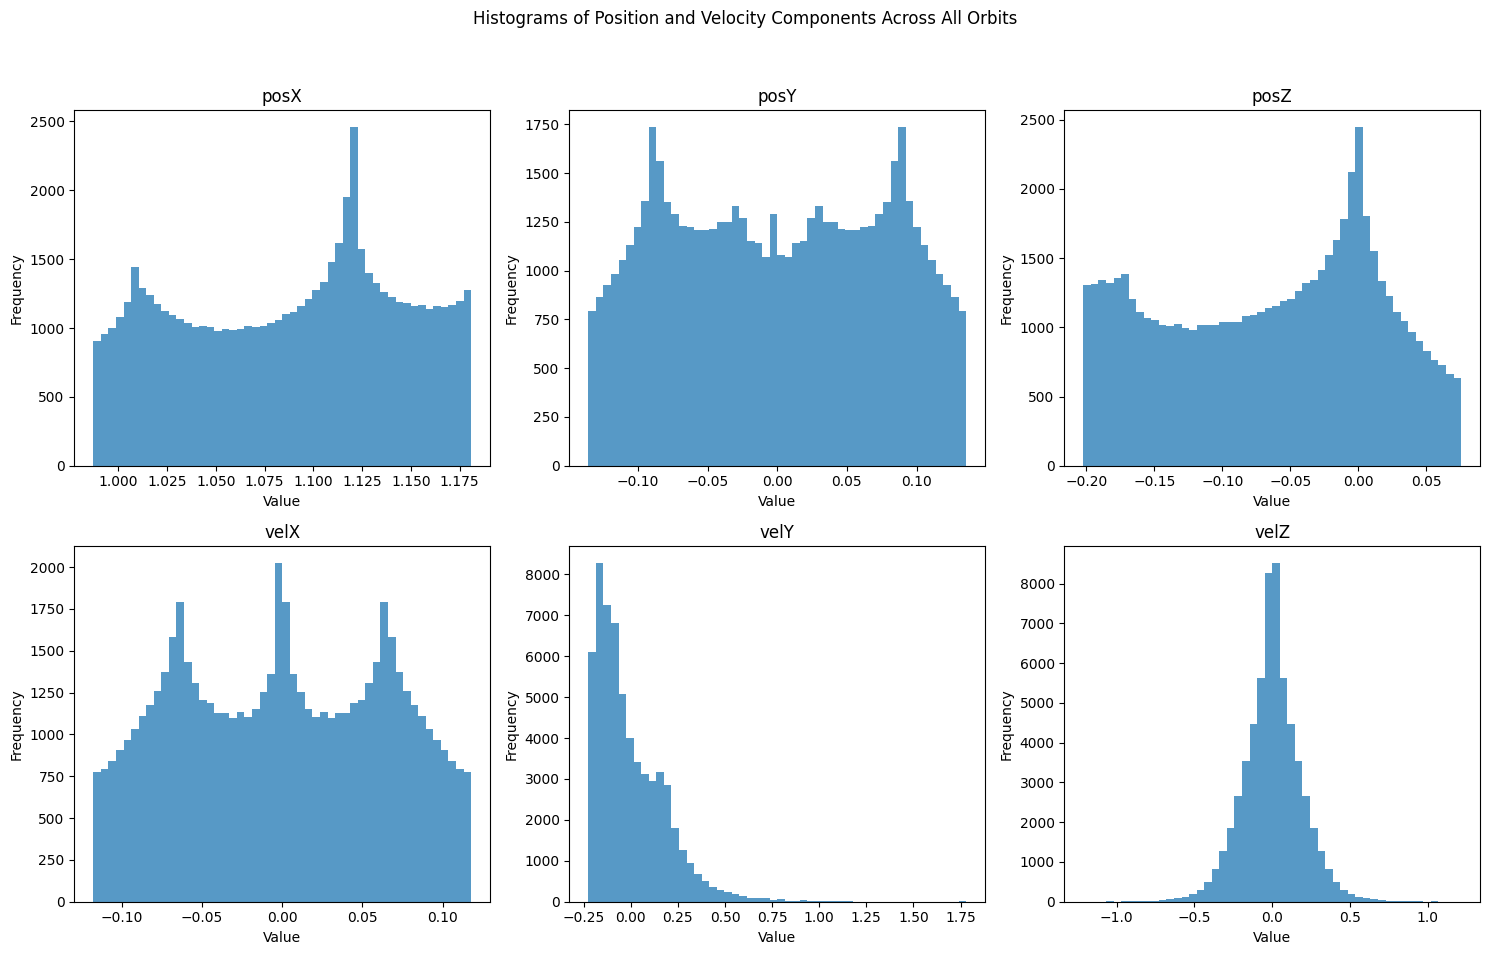

In [ ]:
plot_histograms(mat_data)

In [ ]:
#| export
def calculate_overall_statistics(orbits):
    """
    Calculate the overall min, mean, max, 25%, 50%, and 75% statistics for each scalar 
    (posx, posy, posz, velx, vely, velz) across all time instants and orbits.

    Parameters:
    - orbits: numpy array of shape [number_of_orbits, 6, number_of_time_instants]

    Returns:
    - stats: A dictionary with stats ('min', 'mean', 'max', '25%', '50%', '75%') for each scalar.
    """
    stats = {}
    for scalar_index, scalar_name in enumerate(['posx', 'posy', 'posz', 'velx', 'vely', 'velz']):
        scalar_data = orbits[:, scalar_index, :].flatten()  # Flatten to treat all orbits' data as a single array
        stats[scalar_name] = {
            'min': np.min(scalar_data),
            'mean': np.mean(scalar_data),
            'max': np.max(scalar_data),
            '25%': np.percentile(scalar_data, 25),
            '50%': np.median(scalar_data),  # Median is equivalent to the 50th percentile
            '75%': np.percentile(scalar_data, 75)
        }
    
    return stats

In [ ]:
#| test "basic functionality"
orbits = np.array([
    [[1, 2, 3], [2, 3, 4], [3, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 8]],  # Orbit 1
    [[4, 4, 4], [3, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 8], [7, 8, 9]]   # Orbit 2
])
stats = calculate_overall_statistics(orbits)

assert stats['posx']['min'] == 1, "Min of posx is incorrect"
assert stats['posx']['mean'] == 3, "Mean of posx is incorrect"
assert stats['posx']['max'] == 4, "Max of posx is incorrect"
assert stats['posx']['25%'] == 2.25, "25th percentile of posx is incorrect"
assert stats['posx']['50%'] == 3.5, "Median of posx is incorrect"
assert stats['posx']['75%'] == 4, "75th percentile of posx is incorrect"

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()